# ===============================
# KITTI - Milestone 1
# Data Collection, Exploration & Preprocessing
# ===============================

# Import Libraries

In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# 1. Data Collection

In [4]:
IMAGE_DIR = "data_object_image_2 (1)/training/image_2"
LABEL_DIR = "data_object_label_2/training/label_2"

print("Number of images:", len(os.listdir(IMAGE_DIR)))
print("Number of label files:", len(os.listdir(LABEL_DIR)))

Number of images: 7481
Number of label files: 7481


# 2. Load Labels into Pandas

In [5]:
def load_labels(label_dir):
    rows = []
    for file in os.listdir(label_dir):
        with open(os.path.join(label_dir, file)) as f:
            for line in f:
                parts = line.strip().split()
                cls = parts[0]
                if cls != "DontCare":
                    x1, y1, x2, y2 = map(float, parts[4:8])
                    rows.append([file.replace(".txt", ".png"), cls, x1, y1, x2, y2, x2-x1, y2-y1])
    return pd.DataFrame(rows, columns=["file","class","x1","y1","x2","y2","width","height"])

df = load_labels(LABEL_DIR)
print(df.head())

         file       class      x1      y1      x2      y2   width  height
0  000000.png  Pedestrian  712.40  143.00  810.73  307.92   98.33  164.92
1  000001.png       Truck  599.41  156.40  629.75  189.25   30.34   32.85
2  000001.png         Car  387.63  181.54  423.81  203.12   36.18   21.58
3  000001.png     Cyclist  676.60  163.95  688.98  193.93   12.38   29.98
4  000002.png        Misc  804.79  167.34  995.43  327.94  190.64  160.60


# 3. Data Exploration

C:\Users\VICTUS\AppData\Local\Temp\ipykernel_32656\3438980235.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="class", order=df["class"].value_counts().index, palette="Set2")


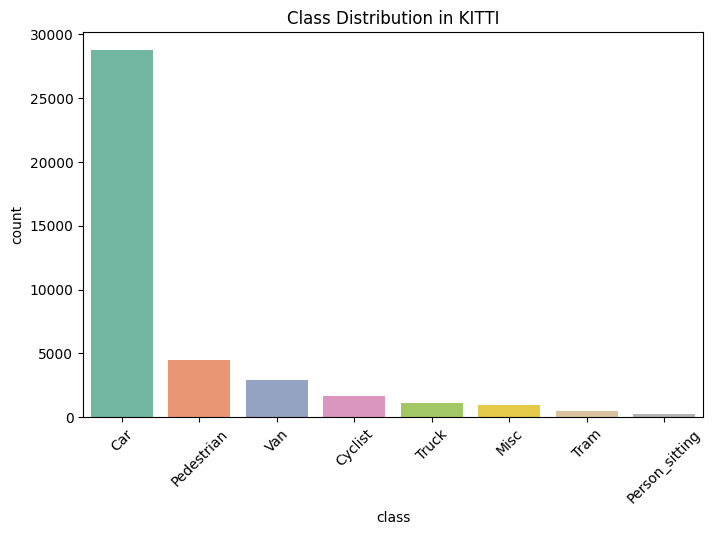

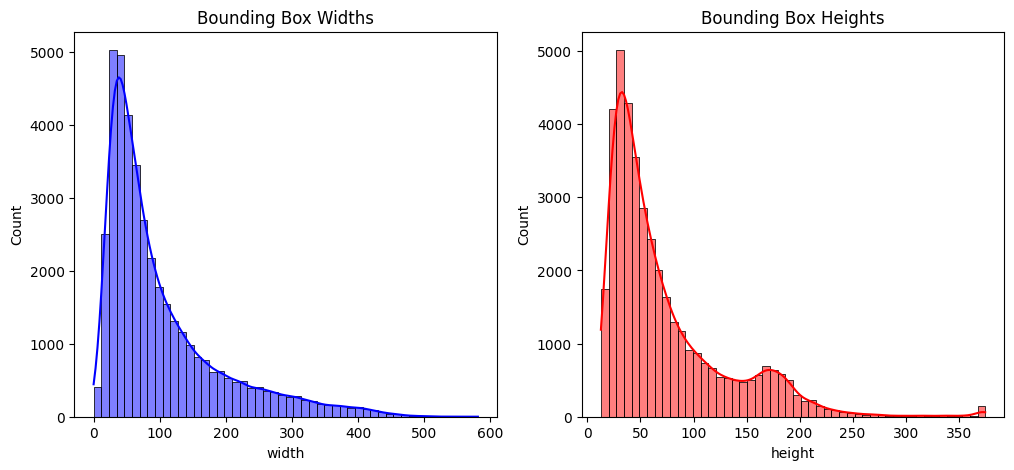

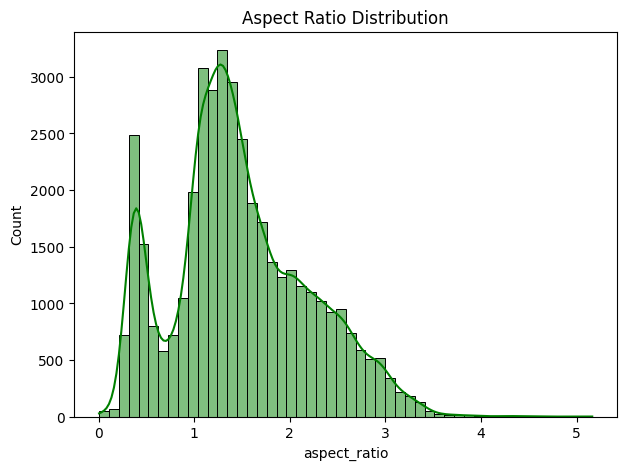

In [6]:
## a) Class distribution
plt.figure(figsize=(8,5))
sns.countplot(data=df, x="class", order=df["class"].value_counts().index, palette="Set2")
plt.title("Class Distribution in KITTI")
plt.xticks(rotation=45)
plt.show()

## b) Bounding box stats
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.histplot(df["width"], bins=50, kde=True, ax=ax[0], color="blue")
ax[0].set_title("Bounding Box Widths")
sns.histplot(df["height"], bins=50, kde=True, ax=ax[1], color="red")
ax[1].set_title("Bounding Box Heights")
plt.show()

## c) Aspect ratio
df["aspect_ratio"] = df["width"] / (df["height"] + 1e-6)
plt.figure(figsize=(7,5))
sns.histplot(df["aspect_ratio"], bins=50, kde=True, color="green")
plt.title("Aspect Ratio Distribution")
plt.show()

# 4. Visualization

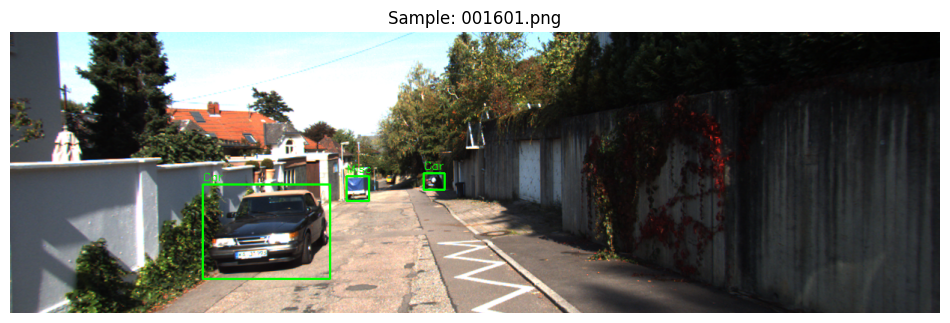

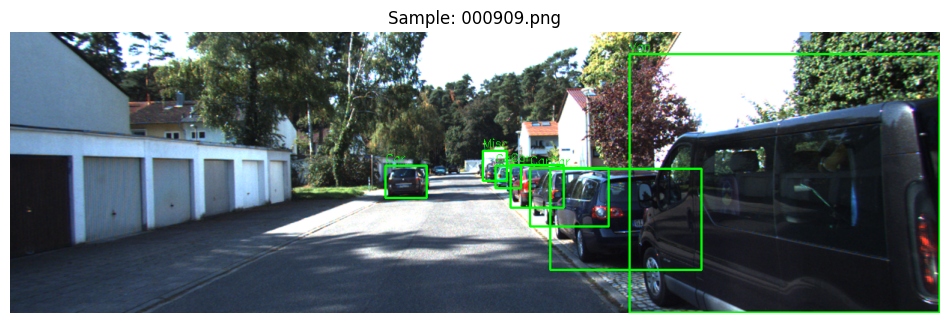

In [7]:
def show_random_image():
    row = df.sample(1).iloc[0]
    img_file = row["file"]
    img = cv2.imread(os.path.join(IMAGE_DIR, img_file))
    subset = df[df["file"] == img_file]

    for _, r in subset.iterrows():
        cv2.rectangle(img, (int(r["x1"]), int(r["y1"])), (int(r["x2"]), int(r["y2"])), (0,255,0), 2)
        cv2.putText(img, r["class"], (int(r["x1"]), int(r["y1"])-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)

    plt.figure(figsize=(12,6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"Sample: {img_file}")
    plt.show()

# Show 2 random samples
for _ in range(2):
    show_random_image()

# 5. Preprocessing

In [8]:
OUTPUT_IMG_DIR = "processed/images"
OUTPUT_LBL_DIR = "processed/labels"
os.makedirs(OUTPUT_IMG_DIR, exist_ok=True)
os.makedirs(OUTPUT_LBL_DIR, exist_ok=True)

TARGET_SIZE = (416, 416)
allowed_classes = ["Car", "Pedestrian", "Cyclist", "Truck"]
class_to_id = {c:i for i,c in enumerate(allowed_classes)}

def convert_to_yolo(size, box):
    dw, dh = 1./size[0], 1./size[1]
    x1, y1, x2, y2 = box
    x = (x1 + x2) / 2.0
    y = (y1 + y2) / 2.0
    w = x2 - x1
    h = y2 - y1
    return (x*dw, y*dh, w*dw, h*dh)

print("Processing images and labels...")

for img_file in os.listdir(IMAGE_DIR):
    img_path = os.path.join(IMAGE_DIR, img_file)
    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    # resize + normalize pixel values [0,1]
    img_resized = cv2.resize(img, TARGET_SIZE)
    img_resized = img_resized / 255.0

    # save image back (scaled to 0-255)
    cv2.imwrite(os.path.join(OUTPUT_IMG_DIR, img_file), (img_resized*255).astype(np.uint8))

    # labels
    yolo_labels = []
    subset = df[df["file"] == img_file]
    for _, r in subset.iterrows():
        if r["class"] in allowed_classes:
            x_scale, y_scale = TARGET_SIZE[0]/w, TARGET_SIZE[1]/h
            x1, y1, x2, y2 = r["x1"]*x_scale, r["y1"]*y_scale, r["x2"]*x_scale, r["y2"]*y_scale
            bb = convert_to_yolo(TARGET_SIZE, (x1,y1,x2,y2))
            yolo_labels.append(f"{class_to_id[r['class']]} " + " ".join(map(str, bb)))

    with open(os.path.join(OUTPUT_LBL_DIR, img_file.replace(".png",".txt")), "w") as out:
        for lbl in yolo_labels:
            out.write(lbl + "\n")

print("✅ Preprocessing done: YOLO-ready dataset in 'processed/'")


Processing images and labels...
✅ Preprocessing done: YOLO-ready dataset in 'processed/'
